# For existing experiment data, forward propagate the next few projections 

In [1]:
# Add the project root to Python path so we can import pyTT
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
print(f"Added {project_root} to Python path")

Added /Users/lfbarba/GitHub/smartTT to Python path


In [2]:
from mumott.data_handling import DataContainer
from mumott import Geometry
import copy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import lovely_tensors as lt
lt.monkey_patch()
%matplotlib widget


INFO:Using multiprocessing.cpu_count() to determine the number of availible CPUs.
INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [3]:
#load data
dc = DataContainer('trabecular_bone_9.h5')

INFO:Inner axis found in dataset base directory. This will override the default.
INFO:Outer axis found in dataset base directory. This will override the default.
INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


In [4]:
#save copy of origial geometry
projections = dc.projections
dc_copy = copy.deepcopy(dc)
geometry_real = dc_copy.geometry
rotations_real = dc_copy.geometry.rotations
joff = dc_copy.geometry.j_offsets
koff = dc_copy.geometry.k_offsets
geometry_real

Field,Size,Data
rotations,247,6ca379 (hash)
j_offsets,247,14c068 (hash)
k_offsets,247,794be2 (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[0. 1. 0.]
k_direction_0,3,[1. 0. 0.]
inner_angles,247,b43664 (hash)
outer_angles,247,3e8e01 (hash)
inner_axes,247,5e6ea6 (hash)
outer_axes,247,3da038 (hash)


In [5]:
projections._projections[20]

Field,Size,Data
data,"(65, 55, 8)",4fb45a (hash)
diode,"(65, 55)",9d7dfe (hash)
weights,"(65, 55, 8)",0e8a84 (hash)
rotation,"(3, 3)",[[ 1.00000e+00 0.00000e+00 0.00000e+00] [ 0.00000e+00 2.22045e-16 1.00000e+00] [ 0.00000e+00 -1.00000e+00 2.22045e-16]]
j_offset,1,-0.25
k_offset,1,-0.3
inner_angle,1,1.5707963267948966
outer_angle,1,0.0
inner_axis,"(3,)",[1. 0. 0.]
outer_axis,"(3,)",[0. 1. 0.]


In [6]:
projections

Field,Size,Data
data,"(247, 65, 55, 8)",250303 (hash)
diode,"(247, 65, 55)",23f78c (hash)
weights,"(247, 65, 55, 8)",1ed87f (hash)
Number of pixels j,1,65
Number of pixels k,1,55


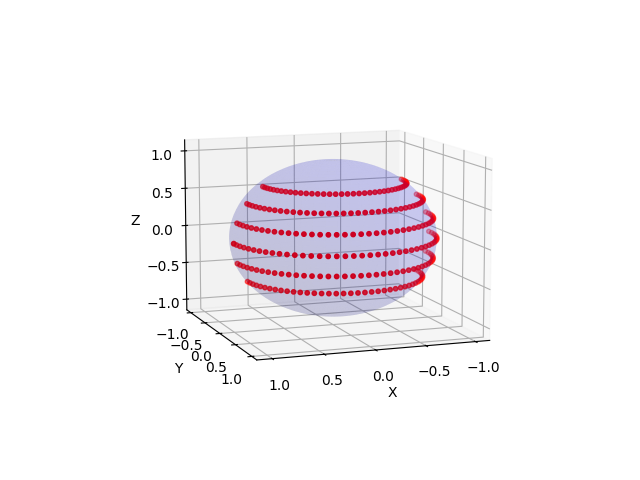

In [7]:
#plot original projections
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2-np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(X, Y, Z, color='b', alpha=0.1)  
ax.scatter(x, y, z, color='r', s=10)  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=70)
plt.show()

In [15]:
import torch
# indices are calculated based on max-min sampling strategy, then m decides how many projections for reconstruction, n decides how many next projections for prediction
m = 60
n = 5
indices_first_120 = torch.randperm(len(projections)).numpy()
indices_to_keep = indices_first_120[:m]
indices_to_predict = indices_first_120[m:m+n]
indices_to_keep, indices_to_predict

(array([ 57, 209,   5, 117, 206, 160,  59,  23, 226, 127, 124,  67, 154,
        157, 217, 172, 180,  76,  80,  69, 129,  52, 238,  40,  28,   6,
        212, 147, 150, 240, 168, 222,  32, 242, 228, 191, 110,  50, 122,
        216, 177,  88, 125, 158,  65,  51,  27, 244, 193,  93,  58, 182,
         30, 119, 126,  62, 227,  71,  78,  36]),
 array([107, 184,  17, 106,  34]))

In [16]:
indices_to_delete = [i for i in range(len(projections)) if i not in indices_to_keep]

In [21]:
from mumott.core.projection_stack import ProjectionStack, Projection
subset_projections = ProjectionStack()
for i in indices_to_keep:
    subset_projections._projections.append(projections._projections[i])

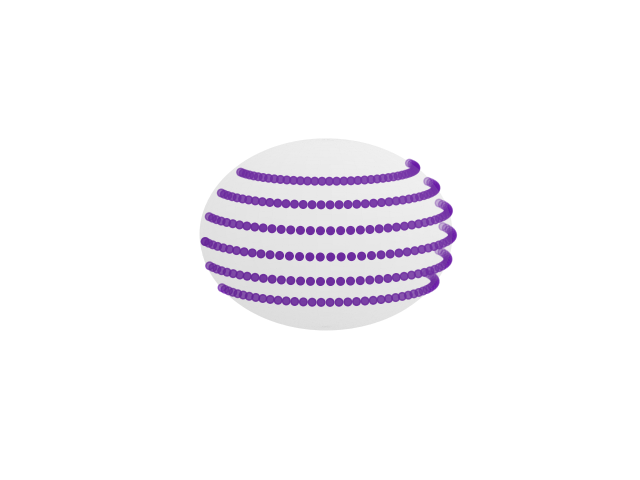

In [24]:
#plot the remaining projections 
rotation_angles_rad = dc.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2 - np.array(dc.geometry.outer_angles))[:]

r = 1
x = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z = r * np.cos(tilt_angles_rad)
color_values = np.arange(len(x))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1)
sc = ax.scatter(x, y, z, color='#6817a6', s=30)  
ax.set_axis_off()
ax.grid(False)
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.view_init(elev=10, azim=70)
plt.tight_layout()
plt.show()

# mumott reconstruction

In [25]:
import h5py
from IPython.display import display
from ipywidgets import interact
from mumott.data_handling import DataContainer
from mumott.output_handling import ProjectionViewer
from mumott.output_handling.saving import dict_to_h5
from mumott.methods.basis_sets import SphericalHarmonics, GaussianKernels
from mumott.methods.projectors import SAXSProjector, SAXSProjectorCUDA
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

In [26]:
import torch
basis_set = SphericalHarmonics(ell_max=8)
projector = SAXSProjectorCUDA(dc.geometry) if torch.cuda.is_available() else SAXSProjector(dc.geometry)
ResidualCalculator = GradientResidualCalculator(
                                data_container=dc,
                                basis_set=basis_set,
                                projector=projector)
loss_function = SquaredLoss(ResidualCalculator)
regularizer = Laplacian()
loss_function.add_regularizer(name='laplacian',
                              regularizer=regularizer,
                              regularization_weight=1)
optimizer = LBFGS(loss_function, maxiter=20)

In [32]:
vector_p, vector_j, vector_k, j_offsets, k_offsets =[torch.tensor(x) for x in projector.john_transform_parameters]
vector_p, vector_j, vector_k, j_offsets, k_offsets

(tensor[247, 3] f64 n=741 (5.8Kb) x∈[-1.000, 1.000] μ=-0.144 σ=0.559,
 tensor[247, 3] f64 n=741 (5.8Kb) x∈[-1.000, 1.000] μ=0.207 σ=0.539,
 tensor[247, 3] f64 n=741 (5.8Kb) x∈[-0.707, 1.000] μ=0.323 σ=0.479,
 tensor[247] f64 1.9Kb x∈[-0.300, 0.800] μ=0.100 σ=0.256,
 tensor[247] f64 1.9Kb x∈[-1.500, 10.069] μ=2.819 σ=3.670)

In [31]:
basis_set

Field,Size,Data
"Maximum ""ell""",1,8
"""ell"" indices",45,[0 2 ... 8 8]
"""emm"" indices",45,[ 0 -2 ... 7 8]
Coefficient projection matrix,"(247, 8, 45)",[[[ 1.00e+00 7.22e-01 ... 8.81e-17 -2.50e-15] [ 1.00e+00 1.74e+00 ... -2.51e-16 -5.00e-16] ... [ 1.00e+00 -1.74e+00 ... 2.51e-16 -1.50e-15] [ 1.00e+00 -7.22e-01 ... -8.81e-17 1.25e-15]] [[ 1.00e+00 7.20e-01 ... -3.49e-02 9.57e-03] [ 1.00e+00 1.74e+00 ... -1.39e-01 -2.29e-02] ... [ 1.00e+00 -1.74e+00 ... 1.39e-01 -2.29e-02] [ 1.00e+00 -7.20e-01 ... 3.49e-02 9.57e-03]] ... [[ 1.00e+00 -4.98e-01 ... 3.42e-01 4.34e-02] [ 1.00e+00 -1.41e+00 ... -3.95e-01 2.48e-01] ... [ 1.00e+00 1.60e+00 ... 1.15e-01 7.19e-01] [ 1.00e+00 7.49e-01 ... -4.40e-01 -3.41e-01]] [[ 1.00e+00 -6.25e-01 ... -4.33e-02 -1.44e-01] [ 1.00e+00 -1.51e+00 ... -1.36e-01 4.72e-01] ... [ 1.00e+00 1.51e+00 ... -1.36e-01 4.72e-01] [ 1.00e+00 6.25e-01 ... -4.33e-02 -1.44e-01]]]
Hash,18,11b2fe


In [18]:
results = optimizer.optimize()

 65%|██████▌   | 13/20 [01:18<00:42,  6.03s/it]


In [30]:
results

{'fun': 629854102701.1257,
 'jac': array([ -7867.88779787,  15137.60659703, -11464.36687419, ...,
         -6985.25307332,  -8137.31445663,   6950.34087096]),
 'nfev': 21,
 'njev': 21,
 'nit': 13,
 'status': 1,
 'message': 'STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT',
 'x': array([[[[ 3.47468018e+00, -3.30599653e+00, -1.86913738e+00, ...,
           -1.95312530e-01,  1.01412057e+00,  2.28035403e+00],
          [-4.03758783e+00,  3.04366300e+00,  1.01564170e+00, ...,
           -4.15546110e+00, -3.16496176e+00,  3.10593575e+00],
          [-2.25517471e-01,  1.41791564e-01, -1.03590693e+00, ...,
           -1.92740499e+00, -1.38378111e+00,  3.09484881e+00],
          ...,
          [ 3.19060005e+00, -2.23147082e+00,  4.82821634e+00, ...,
           -2.86712921e-01, -1.08453616e+00,  3.08019716e+00],
          [ 1.28485099e+01, -7.70586659e+00,  9.21418551e+00, ...,
            6.34385195e-01,  4.37678918e+00,  5.08759657e-01],
          [ 1.13336220e+01, -6.50312056e+00,  8.5582387

In [ ]:
reconstruction = results['x']
reconstruction.shape

array([[[[ 3.47468018e+00, -3.30599653e+00, -1.86913738e+00, ...,
          -1.95312530e-01,  1.01412057e+00,  2.28035403e+00],
         [-4.03758783e+00,  3.04366300e+00,  1.01564170e+00, ...,
          -4.15546110e+00, -3.16496176e+00,  3.10593575e+00],
         [-2.25517471e-01,  1.41791564e-01, -1.03590693e+00, ...,
          -1.92740499e+00, -1.38378111e+00,  3.09484881e+00],
         ...,
         [ 3.19060005e+00, -2.23147082e+00,  4.82821634e+00, ...,
          -2.86712921e-01, -1.08453616e+00,  3.08019716e+00],
         [ 1.28485099e+01, -7.70586659e+00,  9.21418551e+00, ...,
           6.34385195e-01,  4.37678918e+00,  5.08759657e-01],
         [ 1.13336220e+01, -6.50312056e+00,  8.55823877e+00, ...,
           4.94524544e-01,  6.52554822e+00,  4.51923017e-01]],

        [[ 3.51034833e+00, -4.40778852e+00, -5.00852856e-01, ...,
          -7.72615612e-01,  1.49242065e+00,  2.50421768e+00],
         [-1.14133977e+00, -5.00615787e-01,  1.09899031e+00, ...,
          -2.64459712e

In [20]:
# new geometry
reduced_geometry = dc.geometry

In [21]:
sorted_indices_to_keep = sorted(indices_to_keep)
sorted_indices_to_predict = sorted(indices_to_predict)

NameError: name 'indices_to_keep' is not defined

In [23]:
inner_angles = np.loadtxt('bone_in_ang.txt')
outer_angles = np.loadtxt('bone_out_ang.txt')

In [24]:
# sort the indices
inner_angles_new_list = np.array(inner_angles.tolist())[sorted_indices_to_predict].tolist()
outer_angles_new_list = np.array(outer_angles.tolist())[sorted_indices_to_predict].tolist()
rotations_real_new_list = np.array(rotations_real)[sorted_indices_to_predict].tolist()
joff_new_list = np.array(joff)[sorted_indices_to_predict].tolist()
koff_new_list = np.array(koff)[sorted_indices_to_predict].tolist()

# forward propagation

In [22]:
# build a new 'geometry', refer to https://mumott.org/tutorials/simulating_samples.html
from mumott.core.geometry import GeometryTuple
geometry = Geometry()

number_of_projections = n

for i in range(number_of_projections):
    geometry.append(GeometryTuple())

geometry.inner_angles = inner_angles_new_list
geometry.outer_angles = outer_angles_new_list
geometry.p_direction_0 = np.array([0, 0, 1])
geometry.j_direction_0 = np.array([0, 1, 0])
geometry.k_direction_0 = np.array([1, 0, 0])
geometry.inner_axes = np.array([-1, 0, 0])
geometry.outer_axes = np.array([0, -1, 0])
geometry.detector_direction_positive_90 = np.array([0, 1, 0])
geometry.j_offsets = joff_new_list
geometry.k_offsets = koff_new_list

geometry.volume_shape = reconstruction.shape[0:3]
geometry.detector_angles = np.loadtxt('detector_angles.txt')
geometry.projection_shape = np.array((65, 55))
geometry.write('bone_user_geometry.geo')

NameError: name 'n' is not defined

In [26]:
geometry

Field,Size,Data
rotations,5,7b6afa (hash)
j_offsets,5,de8eeb (hash)
k_offsets,5,6a0502 (hash)
p_direction_0,3,[0. 0. 1.]
j_direction_0,3,[0. 1. 0.]
k_direction_0,3,[1. 0. 0.]
inner_angles,5,805490 (hash)
outer_angles,5,d9066e (hash)
inner_axes,5,18e9dc (hash)
outer_axes,5,c2dcf0 (hash)


In [30]:
projector = SAXSProjectorCUDA(geometry) if torch.cuda.is_available() else SAXSProjector(geometry)
basis_set = SphericalHarmonics(ell_max=8, probed_coordinates=geometry.probed_coordinates) 
forward_projections = basis_set.forward(projector.forward(reconstruction.astype(np.float64)))

In [31]:
forward_projections.shape

(5, 65, 55, 8)

In [34]:
basis_set

Field,Size,Data
"Maximum ""ell""",1,8
"""ell"" indices",45,[0 2 ... 8 8]
"""emm"" indices",45,[ 0 -2 ... 7 8]
Coefficient projection matrix,"(5, 8, 45)",[[[ 1. 0.71 ... -0.06 0.04] [ 1. 1.72 ... -0.29 -0.09] ... [ 1. -1.72 ... 0.29 -0.09] [ 1. -0.71 ... 0.06 0.04]] [[ 1. 0.64 ... -0.05 0.34] [ 1. 1.55 ... -1.15 -0.64] ... [ 1. -1.55 ... 1.15 -0.64] [ 1. -0.64 ... 0.05 0.34]] ... [[ 1. 0.11 ... 1.47 2.07] [ 1. 0.27 ... 1.2 0.49] ... [ 1. -0.27 ... -1.2 0.49] [ 1. -0.11 ... -1.47 2.07]] [[ 1. 0.56 ... 0.13 -0.17] [ 1. -0.4 ... 0.2 0.05] ... [ 1. 1.9 ... -0.54 2.04] [ 1. 1.51 ... -1.6 -0.9 ]]]
Hash,17,fd8ab2


In [37]:
# Visualize spherical harmonics available in the reconstructed basis
import ipywidgets as widgets
from IPython.display import display
from matplotlib import cm
from matplotlib.colors import Normalize
from pyTT.visualization import generate_spherical_harmonic_lobes

ell_attr = getattr(basis_set, "ell_max", None)
if ell_attr is None:
    ell_attr = getattr(basis_set, "_ell_max", None)
if ell_attr is None:
    raise AttributeError("Could not determine ell_max from basis_set.")

ell_max_value = int(ell_attr)

l_slider = widgets.IntSlider(min=0, max=ell_max_value, step=1, value=min(ell_max_value, 2), description="ℓ")
m_slider = widgets.IntSlider(min=-ell_max_value, max=ell_max_value, step=1, value=0, description="m")

def _sync_m_slider(change=None):
    m_slider.min = -l_slider.value
    m_slider.max = l_slider.value
    if abs(m_slider.value) > l_slider.value:
        m_slider.value = max(min(m_slider.value, m_slider.max), m_slider.min)

l_slider.observe(_sync_m_slider, names="value")
_sync_m_slider()

def _plot_lobe(l: int, m: int):
    _sync_m_slider()
    lobes = generate_spherical_harmonic_lobes(l=int(l), m=int(m))
    values = lobes.values.cpu().numpy()
    norm = Normalize(vmin=values.min(), vmax=values.max())
    colors = cm.viridis(norm(values))

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(
        lobes.x.cpu().numpy(),
        lobes.y.cpu().numpy(),
        lobes.z.cpu().numpy(),
        facecolors=colors,
        linewidth=0,
        antialiased=False,
        shade=False,
    )
    ax.set_title(f"Spherical harmonic ℓ={int(l)}, m={int(m)}")
    ax.set_axis_off()
    ax.set_box_aspect([1, 1, 1])
    plt.show()

controls = widgets.HBox([l_slider, m_slider])
output = widgets.interactive_output(_plot_lobe, {"l": l_slider, "m": m_slider})
display(widgets.VBox([widgets.HTML("<b>Spherical harmonic explorer</b>"), controls, output]))

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_34216/2041733577.py:75: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  Yc = sph_harm(np.abs(m), l, phi[..., np.newaxis], theta[..., np.newaxis])


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

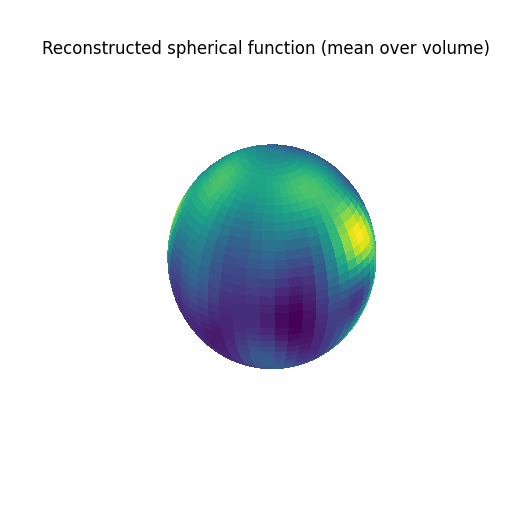

In [28]:
# Render reconstructed spherical function on a single colored sphere

import numpy as np

import matplotlib.pyplot as plt

from matplotlib import cm

from matplotlib.colors import Normalize

from scipy.special import sph_harm



# Retrieve coefficient ordering (ℓ, m) from the basis set

ell_indices = getattr(basis_set, "ell_indices", None)

emm_indices = getattr(basis_set, "emm_indices", None)

if ell_indices is None or emm_indices is None:

    ell_indices = getattr(basis_set, "_ell_indices", None)

    emm_indices = getattr(basis_set, "_emm_indices", None)

if ell_indices is None or emm_indices is None:

    raise AttributeError("Could not access ell/emm indices from basis_set. Tried public and private attributes.")



ell_indices = np.asarray(ell_indices, dtype=int)

emm_indices = np.asarray(emm_indices, dtype=int)



def evaluate_real_sph_harm_grid(ell_idx: np.ndarray,

                                emm_idx: np.ndarray,

                                theta: np.ndarray,

                                phi: np.ndarray) -> np.ndarray:

    """

    Evaluate the real spherical harmonics used by mumott on a (phi, theta) grid

    for all (ℓ, m) pairs in the provided index arrays. Returns an array with shape

    (n_phi, n_theta, n_coeffs) matching the coefficient ordering.



    Mapping follows mumott's SphericalHarmonics implementation:

    Y_real = sqrt(4π) * sqrt(1 + I[m≠0]) * (-1)^m * { Re[Y_l^|m|] if m>=0, Im[Y_l^|m|] if m<0 }

    where Y_l^m are the complex harmonics from scipy.special.sph_harm with Condon-Shortley.

    """

    # Broadcast to grid and last axis = coefficients

    l = ell_idx[np.newaxis, np.newaxis, :]

    m = emm_idx[np.newaxis, np.newaxis, :]



    # Complex spherical harmonics: sph_harm(m, l, phi, theta)

    Yc = sph_harm(np.abs(m), l, phi[..., np.newaxis], theta[..., np.newaxis])



    condon_shortley = (-1.0) ** m

    norm = np.sqrt(4 * np.pi) * np.sqrt(1 + (m != 0).astype(int)) * condon_shortley

    Y_real = norm * ((m >= 0) * Yc.real + (m < 0) * Yc.imag)

    return Y_real



def render_spherical_function(coeffs: np.ndarray,

                               resolution: int = 100,

                               cmap = cm.viridis,

                               title: str = "Reconstructed spherical function (mean coefficients)") -> None:

    coeffs = np.asarray(coeffs)

    assert coeffs.ndim == 1, "Expected a 1D coefficient vector"

    assert coeffs.shape[0] == ell_indices.size, (

        f"Coefficient length {coeffs.shape[0]} does not match basis size {ell_indices.size}")



    # Sphere parameterization

    theta = np.linspace(0.0, np.pi, resolution, dtype=float)          # polar angle [0, π]

    phi = np.linspace(0.0, 2.0 * np.pi, 2 * resolution, dtype=float)  # azimuth [0, 2π)

    PHI, THETA = np.meshgrid(phi, theta, indexing="ij")



    # Evaluate basis on the grid, then combine with coefficients

    Y_real = evaluate_real_sph_harm_grid(ell_indices, emm_indices, THETA, PHI)

    values = np.tensordot(Y_real, coeffs, axes=([2], [0]))  # (n_phi, n_theta)



    # Unit sphere coordinates for plotting

    X = np.sin(THETA) * np.cos(PHI)

    Y = np.sin(THETA) * np.sin(PHI)

    Z = np.cos(THETA)



    vmin, vmax = float(np.nanmin(values)), float(np.nanmax(values))

    norm = Normalize(vmin=vmin, vmax=vmax)

    colors = cmap(norm(values))



    fig = plt.figure(figsize=(5.2, 5.2))

    ax = fig.add_subplot(111, projection="3d")

    surf = ax.plot_surface(X, Y, Z, facecolors=colors, linewidth=0, antialiased=False, shade=False)

    ax.set_title(title)

    ax.set_axis_off()

    ax.set_box_aspect([1, 1, 1])

    # Colorbar using a ScalarMappable

    mappable = cm.ScalarMappable(cmap=cmap, norm=norm)

    mappable.set_array(values)

    fig.colorbar(mappable, shrink=0.75, pad=0.02)

    plt.show()



# Choose coefficients: mean over all voxels (gives a single representative function)

coeffs_mean = reconstruction.reshape(-1, reconstruction.shape[-1]).mean(axis=0)

render_spherical_function(coeffs_mean, resolution=120, title="Reconstructed spherical function (mean over volume)")